In [2]:
from collections import defaultdict
from math import log
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
def train(samples):
    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in samples:
        classes[label] += 1                 # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1          # count features frequencies

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] /= classes[label]
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(samples)
    print(classes, freq)
    return classes, freq                    # return P(C) and P(O|C)

def classify(classifier, feats):
    classes, prob = classifier
    return min(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: -log(classes[cl]) + \
            sum(-log(prob.get((cl,feat), 1e-7)) for feat in feats))

def get_features(sample): return (sample[-1]) # get last letter

samples = (("Anna", "F"), ("Michael", "M"), ("Jane", "F"), ("Ilya", "M"), ("Anthony", "M"))
features = [(get_features(feat), label) for feat, label in samples]
classifier = train(features)

defaultdict(<function train.<locals>.<lambda> at 0x0000020BF9D7C160>, {'F': 0.4, 'M': 0.6}) defaultdict(<function train.<locals>.<lambda> at 0x0000020BF9D7C1F0>, {('F', 'a'): 0.5, ('M', 'l'): 0.3333333333333333, ('F', 'e'): 0.5, ('M', 'a'): 0.3333333333333333, ('M', 'y'): 0.3333333333333333})


In [4]:
classifier

(defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {'F': 0.4, 'M': 0.6}),
 defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {('F', 'a'): 0.5,
              ('M', 'l'): 0.3333333333333333,
              ('F', 'e'): 0.5,
              ('M', 'a'): 0.3333333333333333,
              ('M', 'y'): 0.3333333333333333}))

In [5]:
print('gender: ', classify(classifier, get_features(u'Elizaveta')))


gender:  F


Обучить наивную байесовскую классификацию из файла Sem2.ipynb
(см. вложения) на тренировочном наборе данных. Затем с помощью
метода classify() разметить имена по полу в тестировочном наборе
данных;

In [6]:
data = pd.read_csv('names.csv')
data = data.sample(frac=1).reset_index(drop=True)
learn_data = data.head(180600)
samples = list(zip(learn_data['name'].apply(get_features), learn_data['sex']))
classifier_1 = train(samples)

defaultdict(<function train.<locals>.<lambda> at 0x0000020BC87C0C10>, {'boy': 0.4997065337763012, 'girl': 0.5002934662236987}) defaultdict(<function train.<locals>.<lambda> at 0x0000020BF9D7C790>, {('boy', 'd'): 0.07257858987002339, ('girl', 'a'): 0.38396068752559404, ('girl', 'e'): 0.3008533197569533, ('boy', 'y'): 0.11099537934778995, ('boy', 'e'): 0.13836471018427204, ('girl', 'i'): 0.027115867763106927, ('boy', 'o'): 0.06335944685141888, ('boy', 'l'): 0.08340443449643756, ('boy', 'r'): 0.060179285738030074, ('girl', 'l'): 0.03574867464278995, ('boy', 'n'): 0.21351402262679092, ('girl', 'y'): 0.07910085996037763, ('girl', 'n'): 0.0802519008776687, ('boy', 'a'): 0.01619998448701896, ('boy', 'k'): 0.02273759792569282, ('boy', 'c'): 0.009318869325296133, ('boy', 'h'): 0.026859618602280408, ('boy', 's'): 0.07821866654847252, ('boy', 't'): 0.052566844327235254, ('girl', 'r'): 0.011787101701105663, ('girl', 't'): 0.010868482507498367, ('boy', 'g'): 0.006171950314137866, ('girl', 'g'): 0.0

In [7]:
print('gender: ', classify(classifier_1, get_features(u'Alexey')))

gender:  boy


Посчитайте среднюю долю правильных "ответов"классификатора. Ка-
кие еще метрики можно построить, чтобы оценить, насколько хорошо
справился с задачей данный классификатор?

In [8]:
test_data = data.tail(len(data) - 180600)
test_samples = list(zip(test_data['name'].apply(get_features), test_data['sex']))

correct = 0
for feats, true_label in test_samples:
    predicted_label = classify(classifier_1, feats)
    if predicted_label == true_label:
        correct += 1

accuracy = correct / len(test_samples)
print('Accuracy: ', {accuracy})

Accuracy:  {0.7801808785529716}


Теперь применим метод перекрестного контроля 

In [9]:
learn_data_rev = data.tail(len(data) - 180600)
samples_rev = list(zip(learn_data_rev['name'].apply(get_features), learn_data_rev['sex']))
classifier_1_rev = train(samples_rev)
test_data_rev = data.head(180600) 
test_samples_rev = list(zip(test_data_rev['name'].apply(get_features), test_data_rev['sex']))

correct_rev = 0
for feats, true_label in test_samples_rev:
    predicted_label = classify(classifier_1_rev, feats)
    if predicted_label == true_label:
        correct_rev += 1

accuracy_rev = correct_rev / len(test_samples_rev)
print('Accuracy: ', {accuracy_rev})

defaultdict(<function train.<locals>.<lambda> at 0x0000020BF9D7CDC0>, {'girl': 0.4993152454780362, 'boy': 0.5006847545219638}) defaultdict(<function train.<locals>.<lambda> at 0x0000020BFAF253A0>, {('girl', 'a'): 0.3855409216756799, ('girl', 'e'): 0.3041633244495045, ('girl', 's'): 0.02075193417341579, ('boy', 'e'): 0.13792480582148478, ('girl', 'h'): 0.02478846999767123, ('boy', 'k'): 0.021598327871390603, ('boy', 'r'): 0.06035661755218951, ('boy', 'n'): 0.21655097669857817, ('boy', 's'): 0.07885841096173199, ('girl', 'y'): 0.07752218800941858, ('boy', 'c'): 0.008979949939359534, ('boy', 'a'): 0.015818130209274122, ('boy', 'o'): 0.06257580058318066, ('boy', 'h'): 0.025985085025675432, ('boy', 'm'): 0.016437437101643745, ('girl', 'i'): 0.02856625352550004, ('boy', 'y'): 0.1119655252496581, ('girl', 'l'): 0.03397417652081662, ('boy', 'l'): 0.08154207416200036, ('boy', 'p'): 0.0030191211003019122, ('girl', 'd'): 0.00773669366315626, ('boy', 't'): 0.05313137047454391, ('boy', 'd'): 0.0738

In [10]:
print('Итоговая оценка: ', (accuracy_rev + accuracy)/2)

Итоговая оценка:  0.7782964193429309


Модифицируйте функцию get_features() таким образом, чтобы в
качестве целевого признака бралась другая структура (не последняя
буква имени). Возможно, это будет набор из первой и последней бук-
вы. Или, например, имя целиком...
Будем использовать первую и последнюю букву

In [11]:
def get_features_first(sample):
    last_letter = sample[-1]
    first_letter = sample[0]
    return last_letter,first_letter

In [12]:
learn_data_first = data.head(180600)
samples_first = list(zip(learn_data_first['name'].apply(get_features_first), learn_data_first['sex']))
classifier_first = train(samples_first)

defaultdict(<function train.<locals>.<lambda> at 0x0000020BC87EE1F0>, {'boy': 0.4997065337763012, 'girl': 0.5002934662236987}) defaultdict(<function train.<locals>.<lambda> at 0x0000020BFAF258B0>, {('boy', 'd'): 0.07257858987002339, ('boy', 'C'): 0.07354261083470919, ('girl', 'a'): 0.38396068752559404, ('girl', 'L'): 0.0899361393644926, ('girl', 'e'): 0.3008533197569533, ('girl', 'C'): 0.08336192489458015, ('boy', 'y'): 0.11099537934778995, ('boy', 'G'): 0.04312608729376046, ('boy', 'H'): 0.04056644542200849, ('boy', 'S'): 0.04883264817667069, ('boy', 'e'): 0.13836471018427204, ('boy', 'L'): 0.059447959488958084, ('girl', 'K'): 0.045919891979236994, ('girl', 'A'): 0.09231569510696933, ('girl', 'i'): 0.027115867763106927, ('girl', 'T'): 0.03518422188527221, ('boy', 'o'): 0.06335944685141888, ('boy', 'E'): 0.06618502554101521, ('boy', 'l'): 0.08340443449643756, ('boy', 'M'): 0.06810198676964331, ('girl', 'J'): 0.07199539583633084, ('boy', 'r'): 0.060179285738030074, ('girl', 'l'): 0.0357

In [13]:
test_data_first = data.tail(len(data) - 180600)
test_samples_first = list(zip(test_data_first['name'].apply(get_features_first), test_data_first['sex']))
correct_first = 0
for feats, true_label in test_samples_first:
    predicted_label = classify(classifier_first, feats)
    if predicted_label == true_label:
        correct_first += 1

accuracy_first = correct_first / len(test_samples_first)
print('Accuracy: ', {accuracy_first})


Accuracy:  {0.78343669250646}


Удалось немного повысить точность с помощью добавления первой буквы. Так же были попытки использовать всё имя, длину имени, предпоследнюю букву - точность падала.


Модифицируйте метод classify() так, чтобы вместо логарифмов бра-
лись исходные значения вероятностей, а вместо argmin(...) считался
функционал argmax(...). Также можете использовать другой метод
классификации (из лекций или учебников, или модифицировать его
самому методом проб и ошибок).

In [14]:
def classify_modified(classifier_modified, feats):
    classes, prob = classifier_modified
    return max(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: (classes[cl]) + \
            sum((prob.get((cl,feat), 1e-7)) for feat in feats))



In [15]:
learn_data_modified = data.head(180600)
samples_modified = list(zip(learn_data_modified['name'].apply(get_features_first), learn_data_modified['sex']))
classifier_modified = train(samples_modified)

defaultdict(<function train.<locals>.<lambda> at 0x0000020BFFCC4310>, {'boy': 0.4997065337763012, 'girl': 0.5002934662236987}) defaultdict(<function train.<locals>.<lambda> at 0x0000020BFFCC43A0>, {('boy', 'd'): 0.07257858987002339, ('boy', 'C'): 0.07354261083470919, ('girl', 'a'): 0.38396068752559404, ('girl', 'L'): 0.0899361393644926, ('girl', 'e'): 0.3008533197569533, ('girl', 'C'): 0.08336192489458015, ('boy', 'y'): 0.11099537934778995, ('boy', 'G'): 0.04312608729376046, ('boy', 'H'): 0.04056644542200849, ('boy', 'S'): 0.04883264817667069, ('boy', 'e'): 0.13836471018427204, ('boy', 'L'): 0.059447959488958084, ('girl', 'K'): 0.045919891979236994, ('girl', 'A'): 0.09231569510696933, ('girl', 'i'): 0.027115867763106927, ('girl', 'T'): 0.03518422188527221, ('boy', 'o'): 0.06335944685141888, ('boy', 'E'): 0.06618502554101521, ('boy', 'l'): 0.08340443449643756, ('boy', 'M'): 0.06810198676964331, ('girl', 'J'): 0.07199539583633084, ('boy', 'r'): 0.060179285738030074, ('girl', 'l'): 0.0357

In [16]:
test_data_modified = data.tail(len(data) - 180600)
test_samples_modified = list(zip(test_data_modified['name'].apply(get_features_first), test_data_modified['sex']))
correct_modified = 0
for feats, true_label in test_samples_modified:
    predicted_label = classify_modified(classifier_modified, feats)
    if predicted_label == true_label:
        correct_modified += 1

accuracy_modified = correct_modified / len(test_samples_modified)
print('Accuracy: ', {accuracy_modified})

Accuracy:  {0.77171834625323}


Результат практически не изменился 


Запустите гауссовский и мультиномиальный классификатор методами
из sklearn.naive_bayes. Насколько точна классификация в данном
случае? Какой из трех методов оказался точнее (наивный, гауссовский
или мультиномиальный)?

In [17]:
label_encoder = LabelEncoder()
data['last_letter_encoded'] = label_encoder.fit_transform(data['name'].apply(lambda x: x[-1]))
X = data['last_letter_encoded']
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
gnb_accuracy = accuracy_score(y_test, gnb_pred)
print("Accuracy of Gaussian Naive Bayes :", gnb_accuracy)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)
mnb_accuracy = accuracy_score(y_test, mnb_pred)
print("Accuracy of Multinomial Naive Bayes :", mnb_accuracy)

Accuracy of Gaussian Naive Bayes : 0.7352583979328166
Accuracy of Multinomial Naive Bayes : 0.4993152454780362


Наибольшую точность показал наивный метод с признаком "первая и последняя буква"


Теперь возьмем датасет, содержащий описание цветков ириса и их
классификацию по сортам (Setosa, Versicolour, Virginica). Этот набор
данных содержится в sklearn.datasets.load_iris().
• Разделите данные на обучение и тестировку ;
• С помощью метода LDA (линейный дискриминантный анализ) реали-
зуйте классификацию сортов ириса на основании признаков датасета;

Accuracy: 1.0


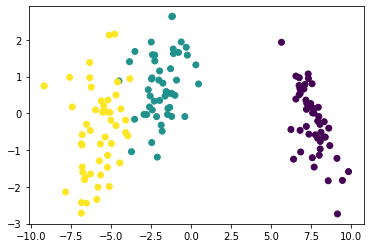

In [18]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
b = lda.fit_transform(X, y)
plt.scatter(b[:, 0],b[:, 1], c=y)
print('Accuracy:', accuracy_score(y_test, y_pred))


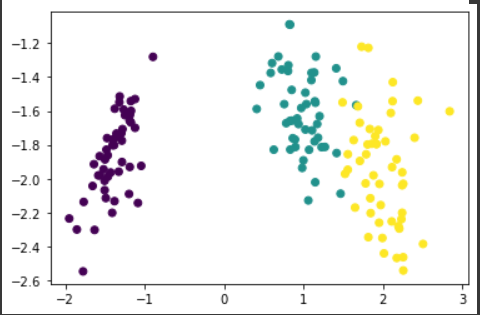

График с семинара


In [19]:
from IPython.display import Image
display(Image('image_2.png'))
print('График с семинара')

Открыть датасет sklearn.datasets.load_wine, содержащий инфор-
мацию о трех различных сортах вина (class0, class1, class2). Ответить
на вопросы ниже, используя средства языка Python и необходимых
библиотек;
• Использовать три подхода к делению выборки на тренировочную и
тестовую: KFold, LOO, Stratified KFold. Для воспроизводимости за-
фиксируйте параметр random_state=42;
• Для каждого из методов кросс-валидации, а также для каждого k ∈ [1, 50]
(число "соседей") прогнать алгоритм ближайших соседей (sklearn.neighbors.KNeighborsClassifier)
и посчитать долю правильных ответов. Какая кросс-валидация и при
каком значении k дает лучший результат?
• Произведите масштабирование признаков с помощью функции sklearn.preprocessing.scale.
Снова найдите оптимальное k на трех разных кросс-валидациях. Че-
му оно равно? Изменилось ли оно? Изменился ли оптимальный метод
валидации?


In [20]:
def evaluate_model(X, y, cv, k_range):
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        fold_scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            fold_scores.append(accuracy_score(y_test, y_pred))
        scores.append(np.mean(fold_scores))
    return scores

In [21]:
wine = datasets.load_wine()
X, y = wine.data, wine.target
random_state = 42

kf = KFold(n_splits=5, random_state=random_state, shuffle=True)
k_range = range(1, 51)
kf_scores = evaluate_model(X, y, kf, k_range)
best_k_kf = k_range[np.argmax(kf_scores)]
best_accuracy_kf = np.max(kf_scores)

print("Best accuracy for KFold:", best_accuracy_kf)
print("Best k value for KFold:", best_k_kf)


loo = LeaveOneOut()
loo_scores = evaluate_model(X, y, loo, k_range)
best_k_loo = k_range[np.argmax(loo_scores)]
best_accuracy_loo = np.max(loo_scores)

print("Best accuracy for Leave-One-Out:", best_accuracy_loo)
print("Best k value for Leave-One-Out:", best_k_loo)


skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
skf_scores = evaluate_model(X, y, skf, k_range)
best_k_skf = k_range[np.argmax(skf_scores)]
best_accuracy_skf = np.max(skf_scores)

print("Best accuracy for Stratified KFold:", best_accuracy_skf)
print("Best k value for Stratified KFold:", best_k_skf)


X_scaled = scale(X)


kf_scaled_scores = evaluate_model(X_scaled, y, kf, k_range)
best_k_kf_scaled = k_range[np.argmax(kf_scaled_scores)]
best_accuracy_kf_scaled = np.max(kf_scaled_scores)

print("Best accuracy for KFold with scaled:", best_accuracy_kf_scaled)
print("Best k value for KFold with scaled:", best_k_kf_scaled)

loo_scaled_scores = evaluate_model(X_scaled, y, loo, k_range)
best_k_loo_scaled = k_range[np.argmax(loo_scaled_scores)]
best_accuracy_loo_scaled = np.max(loo_scaled_scores)

print("Best accuracy for Leave-One-Out with scaled:", best_accuracy_loo_scaled)
print("Best k value for Leave-One-Out with scaled:", best_k_loo_scaled)

skf_scaled_scores = evaluate_model(X_scaled, y, skf, k_range)
best_k_skf_scaled = k_range[np.argmax(skf_scaled_scores)]
best_accuracy_skf_scaled = np.max(skf_scaled_scores)

print("Best accuracy for Stratified KFold with scaled:", best_accuracy_skf_scaled)
print("Best k value for Stratified KFold with scaled:", best_k_skf_scaled)


Best accuracy for KFold: 0.7304761904761905
Best k value for KFold: 1
Best accuracy for Leave-One-Out: 0.7696629213483146
Best k value for Leave-One-Out: 1
Best accuracy for Stratified KFold: 0.7185714285714285
Best k value for Stratified KFold: 1
Best accuracy for KFold with scaled: 0.9776190476190475
Best k value for KFold with scaled: 29
Best accuracy for Leave-One-Out with scaled: 0.9831460674157303
Best k value for Leave-One-Out with scaled: 36
Best accuracy for Stratified KFold with scaled: 0.9776190476190475
Best k value for Stratified KFold with scaled: 13
